Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


🎨 Editing image with instruction: 'Turn the mountains into a futuristic cyberpunk city'...


  0%|          | 0/20 [00:00<?, ?it/s]

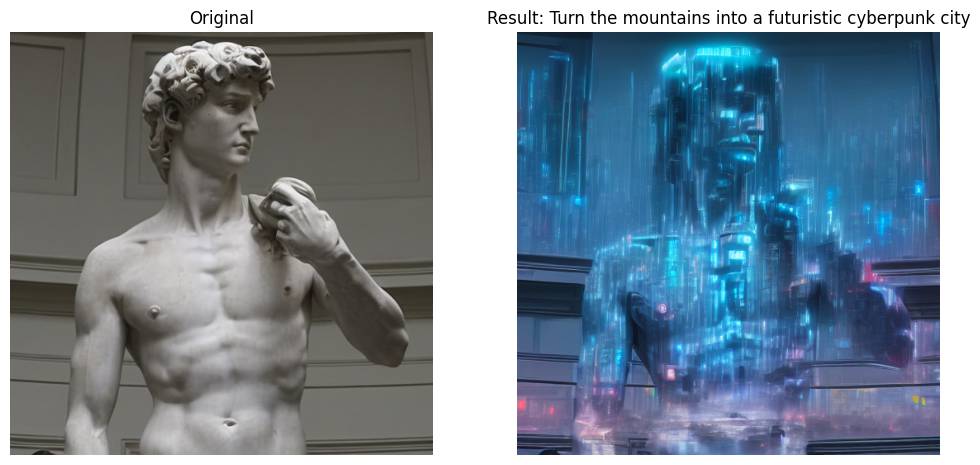

In [ ]:
# 1. Install the magic libraries 📦
# We need 'diffusers' for the AI models and 'accelerate' for speed.
!pip install -q diffusers transformers accelerate torch safetensors

import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
from PIL import Image
import requests
from io import BytesIO

# 2. Load the "Magic Editor" Model 🧠
# This model is specifically trained to follow editing instructions.
model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None
)
pipe.to("cuda") # Send to GPU
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

# 3. Define our simple function 🛠️
def magic_edit(image_url, prompt):
    # Download the image
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    image = image.resize((512, 512)) # Resize for speed

    print(f"🎨 Editing image with instruction: '{prompt}'...")

    # Generate the edit
    # num_inference_steps=20 is a good balance of speed vs quality
    # image_guidance_scale=1.5 keeps the original structure
    result = pipe(prompt, image=image, num_inference_steps=20, image_guidance_scale=1.2).images[0]

    return image, result

# 4. LET'S TRY IT! 🚀
# Replace this URL with any image link (e.g., a photo of a building or person)
input_url = "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"
instruction = "Turn the mountains into a futuristic cyberpunk city"

original, edited = magic_edit(input_url, instruction)

# 5. Display Results
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(original)
axs[0].set_title("Original")
axs[0].axis("off")

axs[1].imshow(edited)
axs[1].set_title(f"Result: {instruction}")
axs[1].axis("off")
plt.show()

In [ ]:
# Install the necessary libraries first
!pip install -q streamlit diffusers transformers accelerate torch safetensors
!npm install -g localtunnel

⠙⠹⠸⠼⠴
changed 22 packages in 722ms
⠴
⠴3 packages are looking for funding
⠴  run `npm fund` for details
⠴

In [19]:
%%writefile app.py
import streamlit as st
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
import torch
from PIL import Image

# --- 🌌 STUDIO CONFIGURATION ---
st.set_page_config(
    page_title="Image Manipulator",
    page_icon="🌌",
    layout="wide",
    initial_sidebar_state="expanded"
)

st.markdown("""
<style>
    /* Main Background - Deep Studio Grey */
    .stApp {
        background-color: #0E1117;
    }

    /* The "Generate" Button - Neon Purple/Blue Gradient */
    .stButton>button {
        width: 100%;
        background: linear-gradient(90deg, #4b6cb7 0%, #182848 100%);
        color: white;
        font-weight: 600;
        border: none;
        border-radius: 8px;
        padding: 0.6rem;
        letter-spacing: 1px;
    }
    .stButton>button:hover {
        opacity: 0.9;
        color: white;
        transform: scale(1.01);
    }

    /* Tabs - Clean & Minimal */
    .stTabs [data-baseweb="tab-list"] {
        gap: 10px;
    }
    .stTabs [data-baseweb="tab"] {
        height: 50px;
        white-space: pre-wrap;
        background-color: #1E1E1E;
        border-radius: 5px;
        color: #B0B0B0;
    }
    .stTabs [aria-selected="true"] {
        background-color: #4b6cb7 !important;
        color: white !important;
    }
</style>
""", unsafe_allow_html=True)

# --- SESSION STATE ---
if 'prompt_input' not in st.session_state:
    st.session_state.prompt_input = "Turn this into a brutalist concrete structure"

def set_prompt(text):
    st.session_state.prompt_input = text

# --- ENGINE LOADING ---
@st.cache_resource
def load_model():
    model_id = "timbrooks/instruct-pix2pix"
    pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        safety_checker=None
    )
    pipe.to("cuda")
    pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
    return pipe

# --- APP LAYOUT ---
# Header
c1, c2 = st.columns([0.5, 5])
with c1:
    st.title("🌌") # Studio Logo Placeholder
with c2:
    st.title("Image Manipulator")
    st.caption("Generative Design Accelerator • Internal Prototype v1.0 | Built by Abhay Sharma")

# Sidebar
with st.sidebar:
    st.header("🎛️ Control Deck")
    uploaded_file = st.file_uploader("Import Visual Asset", type=["png", "jpg", "jpeg"])

    st.markdown("### 📝 Directive")
    prompt = st.text_area("Edit Instruction", key="prompt_input", height=100)

    with st.expander("🛠️ Render Parameters"):
        # Professional naming
        steps = st.slider("Sampling Steps", 10, 50, 25, help="Higher = cleaner detail")
        guidance = st.slider("Text Adherence (CFG)", 1.0, 20.0, 7.5)
        image_guidance = st.slider("Structural Integrity", 1.0, 5.0, 1.4, help="How much to respect the original geometry")

    generate_btn = st.button("🚀 EXECUTE RENDER")

# Main Stage
col1, col2 = st.columns(2)

if uploaded_file:
    input_image = Image.open(uploaded_file).convert("RGB")
    input_image = input_image.resize((512, 512))

    with col1:
        st.subheader("Source Input")
        st.image(input_image, use_container_width=True)

    if generate_btn:
        with col2:
            st.subheader("Render Output")
            with st.spinner("⚡ Processing Neural Edits..."):
                try:
                    pipe = load_model()
                    result = pipe(
                        prompt,
                        image=input_image,
                        num_inference_steps=steps,
                        guidance_scale=guidance,
                        image_guidance_scale=image_guidance
                    ).images[0]
                    st.image(result, use_container_width=True)
                except Exception as e:
                    st.error(f"Render Failed: {e}")
else:
    st.info("👈 Import an asset to begin the workflow.")

# --- 📂 STUDIO PRESETS (Matching Job Description) ---
st.markdown("---")
st.subheader("📂 Quick Workflows")

t1, t2, t3 = st.tabs(["🏗️ Architecture", "🛋️ Interiors", "🎬 Concept Art"])

with t1:
    c1, c2, c3 = st.columns(3)
    c1.button("🏢 Glass Facade", on_click=set_prompt, args=["Turn the building into a modern glass skyscraper with green terraces"])
    c2.button("🧱 Brutalist", on_click=set_prompt, args=["Turn this into a raw concrete brutalist structure"])
    c3.button("🌿 Eco-Futurism", on_click=set_prompt, args=["Add vertical gardens and futuristic solar panels"])

with t2:
    c1, c2, c3 = st.columns(3)
    c1.button("💡 Warm Lighting", on_click=set_prompt, args=["Change the lighting to warm cozy sunset interior lighting"])
    c2.button("⚪ Minimalist", on_click=set_prompt, args=["Make the room white, minimalist, and spacious"])
    c3.button("🏚️ Abandoned", on_click=set_prompt, args=["Make the room look abandoned, dusty, and overgrown"])

with t3:
    c1, c2, c3 = st.columns(3)
    c1.button("🖌️ Oil Painting", on_click=set_prompt, args=["Turn this into a detailed oil painting style"])
    c2.button("🎞️ Cinematic", on_click=set_prompt, args=["Make it look like a cinematic movie shot with anamorphic lens flare"])
    c3.button("🌃 Cyberpunk", on_click=set_prompt, args=["Turn this into a cyberpunk night city scene with neon lights"])

Overwriting app.py


In [18]:
# 1. Download Cloudflare Tunnel ☁️
!wget -q -nc https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64

# 2. Run Streamlit in the background
!streamlit run app.py &>/dev/null&

# 3. Expose via Cloudflare (No password needed!)
# This will give you a link ending in .trycloudflare.com
print("⏳ Waiting for Cloudflare link...")
import time
import re
import subprocess

# Start the tunnel
proc = subprocess.Popen(["./cloudflared-linux-amd64", "tunnel", "--url", "http://localhost:8501"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Read the output to find the URL
time.sleep(4) # Give it a moment to start
found_url = False
while not found_url:
    line = proc.stderr.readline().decode("utf-8")
    if "trycloudflare.com" in line:
        url = re.search(r"https://[a-zA-Z0-9-]+\.trycloudflare\.com", line)
        if url:
            print(f"🚀 YOUR APP IS LIVE HERE: {url.group(0)}")
            found_url = True

⏳ Waiting for Cloudflare link...
🚀 YOUR APP IS LIVE HERE: https://lotus-evanescence-weather-anaheim.trycloudflare.com
